# Cosmic-ray flux vs. sky position

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,scipy,pandas,sklearn,mlxtend

last updated: 2018-08-03 

CPython 2.7.13
IPython 5.7.0

numpy 1.14.5
scipy 1.1.0
pandas 0.23.1
sklearn 0.19.1
mlxtend 0.12.0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from __future__ import division, print_function
import os
import sys
from numbers import Number
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import dask
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import dask.array as da
import pyunfold

import comptools as comp
import sky_anisotropy as sa

color_dict = comp.color_dict

%matplotlib inline

In [4]:
config = 'IC86.2012'
num_groups = 2

comp_list = comp.get_comp_list(num_groups=num_groups)
energybins = comp.get_energybins(config)
num_ebins = len(energybins.log_energy_midpoints)

unfolding_dir  = os.path.join(comp.paths.comp_data_dir,
                              config,
                              'unfolding')

In [5]:
# Load DataFrame with saved prior distributions
df_file = os.path.join(unfolding_dir,
                       'unfolding-df_{}-groups.hdf'.format(num_groups))
df_priors = pd.read_hdf(df_file)
df_priors.head()

,counts,counts_err,efficiencies,efficiencies_err,broken_power_law_flux,broken_power_law_prior,simple_power_law_flux,simple_power_law_prior,H3a_flux,H3a_prior,H4a_flux,H4a_prior
log_energy_bin_idx,,,,,,,,,,,,
0,1071404.0,1035.086470,0.007119,0.000084,1.416780e-12,0.231674,1.416780e-12,0.231486,7.187420e-13,0.302586,7.333020e-13,0.306455
1,743932.0,862.514927,0.006400,0.000078,1.416780e-12,0.231674,1.416780e-12,0.231486,4.082709e-13,0.171880,4.023280e-13,0.168137
2,851277.0,922.646736,0.007928,0.000075,7.608561e-13,0.124416,7.608561e-13,0.124315,3.743101e-13,0.157582,3.821589e-13,0.159708
3,702982.0,838.440219,0.007473,0.000068,7.608561e-13,0.124416,7.608561e-13,0.124315,2.232925e-13,0.094005,2.198728e-13,0.091887
4,579872.0,761.493270,0.008373,0.000068,4.086039e-13,0.066816,4.086039e-13,0.066761,1.925426e-13,0.081059,1.967681e-13,0.082231


In [6]:
# Load simulation and train composition classifier
df_sim_train, df_sim_test = comp.load_sim(config=config,
#                                           energy_reco=True,
                                          energy_reco=False,
                                          log_energy_min=None,
                                          log_energy_max=None,
                                          test_size=0.5,
                                          n_jobs=10,
                                          verbose=True)

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/dask/base.py:835: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "


[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  0.1s


In [7]:
feature_list, feature_labels = comp.get_training_features()

In [14]:
print('Running energy reconstruction...')
energy_pipeline_name = 'linearregression'
# energy_pipeline_name = 'RF'
energy_pipeline = comp.load_trained_model('{}_energy_{}'.format(energy_pipeline_name, config))
for df in [df_sim_train, df_sim_test]:
    # Energy reconstruction
    df['reco_log_energy'] = energy_pipeline.predict(df[feature_list].values)
    df['reco_energy'] = 10**df['reco_log_energy']

Running energy reconstruction...


In [15]:
# Load fitted efficiencies and calculate effective areas
# eff_path = os.path.join(comp.paths.comp_data_dir, config, 'efficiencies',
#                         'efficiency_fit_num_groups_{}.hdf'.format(num_groups))
eff_path = comp.get_efficiencies_file(config=config,
                                      num_groups=num_groups,
                                      sigmoid='slant')
df_eff = pd.read_hdf(eff_path)
df_eff.head()

,eff_median_light,eff_err_low_light,eff_err_high_light,eff_median_heavy,eff_err_low_heavy,eff_err_high_heavy,eff_median_total,eff_err_low_total,eff_err_high_total
0,0.007116,0.000083,0.000084,0.006401,0.000086,0.000076,0.006736,0.000051,0.000058
1,0.007926,0.000072,0.000065,0.007473,0.000066,0.000069,0.007684,0.000045,0.000047
2,0.008371,0.000065,0.000067,0.008009,0.000065,0.000063,0.008192,0.000043,0.000047
3,0.008609,0.000071,0.000062,0.008274,0.000068,0.000064,0.008456,0.000045,0.000048
4,0.008735,0.000072,0.000067,0.008426,0.000066,0.000064,0.008601,0.000045,0.000049


In [16]:
# Get simulation thrown areas for each energy bin
thrown_radii = comp.simfunctions.get_sim_thrown_radius(energybins.log_energy_midpoints)
thrown_area = np.max(np.pi * thrown_radii**2)
thrown_area

9079202.768874502

In [17]:
efficiencies, efficiencies_err = comp.get_detector_efficiencies(config=config,
                                                                num_groups=num_groups,
                                                                sigmoid='slant',
                                                                pyunfold_format=True)

In [18]:
efficiencies

array([0.00711621, 0.00640114, 0.00792564, 0.00747336, 0.00837118,
       0.00800932, 0.00860879, 0.00827434, 0.00873487, 0.00842553,
       0.00880808, 0.00853552, 0.00885811, 0.00862577, 0.00889926,
       0.00871167, 0.00893319, 0.00879576, 0.00896376, 0.0088786 ,
       0.00899596, 0.00896131, 0.00902511, 0.00904439, 0.00905524,
       0.00912615, 0.00908302, 0.00920706, 0.00911336, 0.00928806,
       0.00914197, 0.00936856, 0.00917137, 0.00944958, 0.009201  ,
       0.00953194, 0.00922881, 0.00961275])

In [19]:
print('Running composition classifications...')
pipeline_str = 'xgboost_comp_{}_{}-groups'.format(config, num_groups)
comp_pipeline = comp.load_trained_model(pipeline_str)
pred_target = comp_pipeline.predict(df_sim_test[feature_list].values)

Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [20]:
df_sim_test['pred_comp_target'] = pred_target

In [21]:
print('Making response matrix...')
log_reco_energy_sim_test = df_sim_test['reco_log_energy']
log_true_energy_sim_test = df_sim_test['MC_log_energy']
true_target = df_sim_test['comp_target_{}'.format(num_groups)].values

response, response_err = comp.response_matrix(true_energy=log_true_energy_sim_test,
                                              reco_energy=log_reco_energy_sim_test,
                                              true_target=true_target,
                                              pred_target=pred_target,
                                              efficiencies=efficiencies,
                                              efficiencies_err=efficiencies_err,
                                              energy_bins=energybins.log_energy_bins)

Making response matrix...


/home/jbourbeau/cr-composition/comptools/data_functions.py:25: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.abs(ratio) * np.sqrt((num_err / num)**2 + (den_err / den)**2)


In [22]:
np.testing.assert_allclose(response.sum(axis=0), efficiencies)

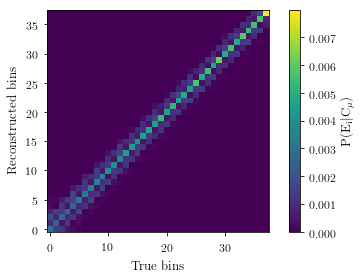

In [30]:
fig, ax = plt.subplots()
im = ax.imshow(response, origin='lower')
plt.colorbar(im, label='$\mathrm{P(E_i | C_{\mu})}$')
ax.set_xlabel('True bins')
ax.set_ylabel('Reconstructed bins')

outfile = os.path.join(comp.paths.figures_dir,
                       'unfolding',
                       config,
                       'response_matrix',
                       'response-matrix_{}-groups.png'.format(num_groups))
plt.savefig(outfile)

plt.show()

In [31]:
# print('Loading data into memory...')
# df_data = comp.load_data(config=config,
#                          energy_reco=True,
#                          log_energy_min=6.1,
#                          log_energy_max=8.0,
#                          columns=feature_list + ['lap_ra', 'lap_dec'],
#                          n_jobs=20,
#                          verbose=True)

In [32]:
# df_data.to_hdf('data_dataframe.hdf', 'dataframe', format='table')

In [33]:
df_data = pd.read_hdf('data_dataframe.hdf', 'dataframe', mode='r')

In [34]:
df_data.shape

(6668215, 7)

In [35]:
energybins.log_energy_bins

array([6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3,
       7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ])

In [36]:
df_data.reco_log_energy.min(), df_data.reco_log_energy.max()

(6.100001266909608, 7.979532177403555)

In [37]:
print('Running energy reconstruction...')
for df in [df_data]:
    # Energy reconstruction
    df['reco_log_energy'] = energy_pipeline.predict(df[feature_list].values)
    df['reco_energy'] = 10**df['reco_log_energy']

Running energy reconstruction...


In [38]:
df_data.reco_log_energy.min(), df_data.reco_log_energy.max()

(6.04731940764387, 9.659801452825425)

### Data declination distribution

In [39]:
ra = df_data.loc[:, 'lap_ra'].values
dec = df_data.loc[:, 'lap_dec'].values

In [40]:
dec_median = df_data.loc[:, 'lap_dec'].median()
dec_median_deg = np.rad2deg(dec_median)

dec_median = -1.30927265203 [rad]
dec_median = -75.0157971934 [deg]


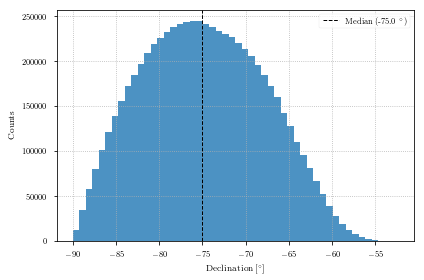

In [28]:
fig, ax = plt.subplots()
ax.hist(np.rad2deg(dec), bins=50, alpha=0.8)
print('dec_median = {} [rad]'.format(dec_median))
print('dec_median = {} [deg]'.format(dec_median_deg))
ax.axvline(dec_median_deg, marker='None', ls='--', lw=1, color='k',
           label='Median ({:0.1f}'.format(dec_median_deg)+' $^{\circ}$)')
# ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('Declination [$^{\circ}$]')
ax.set_ylabel('Counts')
ax.grid()
ax.legend()
outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'declination_hist.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)
plt.show()

In [41]:
from itertools import cycle
from matplotlib.animation import FuncAnimation

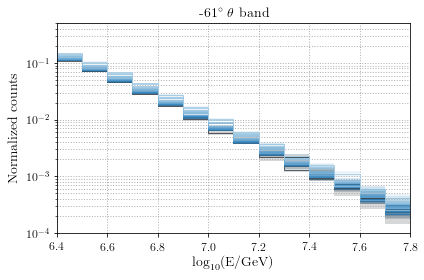

In [44]:
# fig, ax = plt.subplots(figsize=(8, 4))
fig, ax = plt.subplots()
dec_step = 1
# dec_mins = np.arange(-90, -75, dec_step)
dec_mins = np.arange(-90, -60, dec_step)
colors = cycle(sns.color_palette('Blues_d', len(dec_mins)).as_hex())
# colors = ['C{}'.format(i) for i in range(len(dec_mins))]

def update_plot(num):
#     ax.clear()
    dec_min_deg = dec_mins[num]
#     print('dec_min_deg = {}'.format(dec_min_deg))
    dec_max_deg = dec_min_deg + dec_step

    dec_min = np.deg2rad(dec_min_deg)
    dec_max = np.deg2rad(dec_max_deg)

    dec_mask = (df_data['lap_dec'] <= dec_max) & (df_data['lap_dec'] >= dec_min)
    counts, _ = np.histogram(df_data.loc[dec_mask, 'reco_log_energy'],
                             bins=energybins.log_energy_bins)
    counts_err = np.sqrt(counts)
    norm = np.sum(counts)
    norm_err = comp.data_functions.get_summation_error(counts_err)
    norm_counts, norm_counts_err = comp.data_functions.ratio_error(counts, counts_err, norm, norm_err)
    
    label = str(dec_min_deg) + '$^{\circ}$' + ' $\\theta$ band'
    color = next(colors)
    comp.plot_steps(energybins.log_energy_bins,
                    norm_counts,
                    yerr=norm_counts_err, 
#                     label=label,
                    color=color,
                    alpha=0.8,
                    ax=ax)
    
    ax.set_yscale('log', nonposy='clip')
    ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
    ax.set_ylabel('Normalized counts')
    ax.set_title(label)
    ax.set_xlim(6.4, 7.8)
    ax.set_ylim(1e-4, 5e-1)
    ax.grid(linestyle='dotted', which="both")

    return ax
    

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-dec-bands-energy-hist.gif'.format(config))

def init():
    pass

anim = FuncAnimation(fig, update_plot, frames=len(dec_mins), init_func=init, interval=1250)
anim.save(outfile, dpi=300, writer='imagemagick')

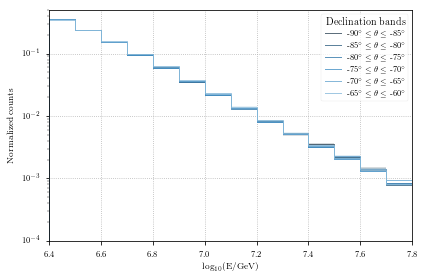

In [31]:
fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(8, 4))
dec_step = 5
dec_mins = np.arange(-90, -60, dec_step)
colors = cycle(sns.color_palette('Blues_d', len(dec_mins)).as_hex())
# colors = ['C{}'.format(i) for i in range(len(dec_mins))]
for dec_min_deg, color in zip(dec_mins, colors):
    dec_max_deg = dec_min_deg + dec_step

    dec_min = np.deg2rad(dec_min_deg)
    dec_max = np.deg2rad(dec_max_deg)

    dec_mask = (df_data['lap_dec'] <= dec_max) & (df_data['lap_dec'] >= dec_min)
    energy_mask = (df_data['reco_log_energy'] <= 7.8) & (df_data['reco_log_energy'] >= 6.4)
    
    counts, _ = np.histogram(df_data.loc[dec_mask & energy_mask, 'reco_log_energy'],
                             bins=energybins.log_energy_bins)
    counts_err = np.sqrt(counts)
    norm = np.sum(counts)
    norm_err = comp.data_functions.get_summation_error(counts_err)
    norm_counts, norm_counts_err = comp.data_functions.ratio_error(counts, counts_err, norm, norm_err)
    
#     norm_counts = counts / np.sum(counts)
#     norm_counts_err = counts_err / np.sum(counts)
    
#     label = str(dec_min_deg) + '$^{\circ}$'
    label = str(dec_min_deg) + '$^{\circ}\leq \\theta \leq$ ' + str(dec_max_deg) + '$^{\circ}$'
    comp.plot_steps(energybins.log_energy_bins, norm_counts,
                    yerr=norm_counts_err, 
                    label=label,
                    color=color,
                    alpha=0.8,
                    ax=ax)
ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('Normalized counts')
ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e-4, 5e-1)
ax.grid()
ax.legend(title='Declination bands')
# ax.legend(title='Declination bands', 
#           loc='center left',
#           bbox_to_anchor=(1, 0.5), 
#           ncol=3)

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-dec-bands-energy-hist-{}.png'.format(config, energy_pipeline_name))
plt.savefig(outfile)

plt.show()

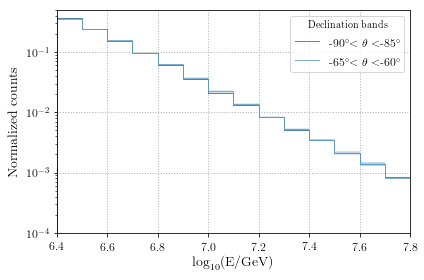

In [76]:
fig, ax = plt.subplots()
decs = [(-90, -85), (-65, -60)]
colors = cycle(sns.color_palette('Blues_d', len(decs)).as_hex())
for d, color in zip(decs, colors):
    dec_min_deg, dec_max_deg = d

    dec_min = np.deg2rad(dec_min_deg)
    dec_max = np.deg2rad(dec_max_deg)

    dec_mask = (df_data['lap_dec'] <= dec_max) & (df_data['lap_dec'] >= dec_min)
    energy_mask = (df_data['reco_log_energy'] <= 7.8) & (df_data['reco_log_energy'] >= 6.4)
    counts, _ = np.histogram(df_data.loc[dec_mask & energy_mask, 'reco_log_energy'],
                             bins=energybins.log_energy_bins)
    counts_err = np.sqrt(counts)
    norm = np.sum(counts)
    norm_err = comp.data_functions.get_summation_error(counts_err)
    norm_counts, norm_counts_err = comp.data_functions.ratio_error(counts, counts_err, norm, norm_err)
    
#     norm_counts = counts / np.sum(counts)
#     norm_counts_err = counts_err / np.sum(counts)
    
    label = str(dec_min_deg) + '$^{\circ}$' + '$< \\theta < $' + str(dec_max_deg) + '$^{\circ}$'
#     label = str(dec_min_deg) + '$^{\circ}\leq \\theta \leq$ ' + str(dec_max_deg) + '$^{\circ}$'
    comp.plot_steps(energybins.log_energy_bins, norm_counts,
                    yerr=norm_counts_err, 
                    label=label,
                    color=color,
                    alpha=0.8,
                    ax=ax)
ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('Normalized counts')
ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e-4, 5e-1)
ax.grid()
ax.legend(title='Declination bands')
# ax.legend(title='Declination bands', 
#           loc='center left',
#           bbox_to_anchor=(1, 0.5), 
#           ncol=3)

# outfile = os.path.join(comp.paths.figures_dir,
#                        'skymaps',
#                        '{}-dec-bands-energy-hist-{}.png'.format(config, energy_pipeline_name))
# plt.savefig(outfile)

plt.show()

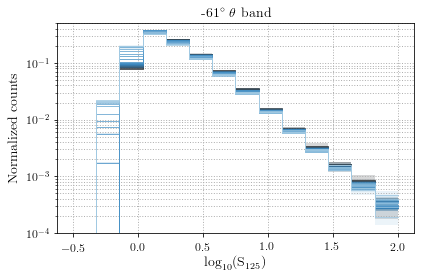

In [35]:
log_s125_bins = np.linspace(-0.5, 2, 15)

# fig, ax = plt.subplots(figsize=(8, 4))
fig, ax = plt.subplots()
dec_step = 1
# dec_mins = np.arange(-90, -75, dec_step)
dec_mins = np.arange(-90, -60, dec_step)
colors = cycle(sns.color_palette('Blues_d', len(dec_mins)).as_hex())
# colors = ['C{}'.format(i) for i in range(len(dec_mins))]

def update_plot(num):
#     ax.clear()
    dec_min_deg = dec_mins[num]
#     print('dec_min_deg = {}'.format(dec_min_deg))
    dec_max_deg = dec_min_deg + dec_step

    dec_min = np.deg2rad(dec_min_deg)
    dec_max = np.deg2rad(dec_max_deg)

    dec_mask = (df_data['lap_dec'] <= dec_max) & (df_data['lap_dec'] >= dec_min)
    counts, _ = np.histogram(df_data.loc[dec_mask, 'log_s125'],
                             bins=log_s125_bins)
    counts_err = np.sqrt(counts)
    norm = np.sum(counts)
    norm_err = comp.data_functions.get_summation_error(counts_err)
    norm_counts, norm_counts_err = comp.data_functions.ratio_error(counts, counts_err, norm, norm_err)
    
    label = str(dec_min_deg) + '$^{\circ}$' + ' $\\theta$ band'
    color = next(colors)
    comp.plot_steps(log_s125_bins,
                    norm_counts,
                    yerr=norm_counts_err, 
#                     label=label,
                    color=color,
                    alpha=0.8,
                    ax=ax)
    
    ax.set_yscale('log', nonposy='clip')
    ax.set_xlabel('$\mathrm{\log_{10}(S_{125})}$')
    ax.set_ylabel('Normalized counts')
    ax.set_title(label)
#     ax.set_xlim(6.4, 7.8)
    ax.set_ylim(1e-4, 5e-1)
    ax.grid(linestyle='dotted', which="both")

    return ax
    

def init():
    pass

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-dec-bands-s125-hist.gif'.format(config))

anim = FuncAnimation(fig, update_plot, frames=len(dec_mins), init_func=init, interval=1250)
anim.save(outfile, dpi=300, writer='imagemagick')

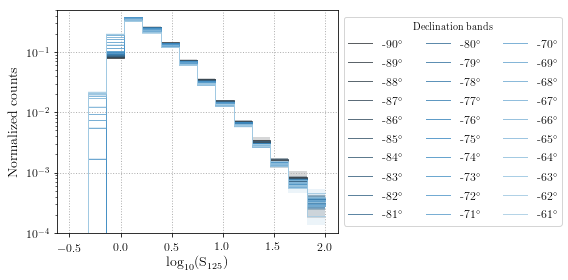

In [36]:
log_s125_bins = np.linspace(-0.5, 2, 15)

dec_step = 1
dec_mins = np.arange(-90, -60, dec_step)
colors = cycle(sns.color_palette('Blues_d', len(dec_mins)).as_hex())
# colors = ['C{}'.format(i) for i in range(len(dec_mins))]
fig, ax = plt.subplots(figsize=(8, 4))
for dec_min_deg, color in zip(dec_mins, colors):
    dec_max_deg = dec_min_deg + dec_step

    dec_min = np.deg2rad(dec_min_deg)
    dec_max = np.deg2rad(dec_max_deg)

    dec_mask = (df_data['lap_dec'] <= dec_max) & (df_data['lap_dec'] >= dec_min)
    counts, _ = np.histogram(df_data.loc[dec_mask, 'log_s125'],
                             bins=log_s125_bins)
    counts_err = np.sqrt(counts)
    norm = np.sum(counts)
    norm_err = comp.data_functions.get_summation_error(counts_err)
    norm_counts, norm_counts_err = comp.data_functions.ratio_error(counts, counts_err, norm, norm_err)
    
    label = str(dec_min_deg) + '$^{\circ}$'
#     label = str(dec_min_deg) + '$^{\circ}\leq \\theta \leq$ ' + str(dec_max_deg) + '$^{\circ}$'
    comp.plot_steps(log_s125_bins, norm_counts,
                    yerr=norm_counts_err, 
                    label=label,
                    color=color,
                    alpha=0.8,
                    ax=ax)
ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(S_{125})}$')
ax.set_ylabel('Normalized counts')
ax.set_ylim(1e-4, 5e-1)
ax.grid()
# ax.legend(title='Declination bands')
ax.legend(title='Declination bands', 
          loc='center left',
          bbox_to_anchor=(1, 0.5), 
          ncol=3)

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-dec-bands-s125-hist.png'.format(config))
plt.savefig(outfile)

plt.show()

### Multi-dimensional binning

In [131]:
dataset = df_data.sample(frac=1, random_state=2)
# dataset = df_data.sample(n=5000, random_state=2)
dataset.head()

,lap_cos_zenith,log_s125,log_dEdX,lap_ra,lap_dec,reco_log_energy,reco_energy,pred_comp_target,pix
IC86.2012_120655_29962215_0,0.948837,0.135644,0.593995,2.073858,-1.249081,6.169086,1.475999e+06,0,47782
IC86.2012_122121_54516804_0,0.983440,0.079695,0.947784,4.874247,-1.388858,6.156973,1.435400e+06,0,48775
IC86.2012_120638_44599117_0,0.967261,0.306750,1.360893,4.777504,-1.314318,6.391767,2.464717e+06,1,48372
IC86.2012_122272_12840642_0,0.979178,0.075470,1.027414,0.953697,-1.367112,6.152934,1.422111e+06,1,48617
IC86.2012_120399_61211317_1,0.871608,0.317658,1.671331,4.073173,-1.057723,6.519127,3.304665e+06,1,45975


In [109]:
dec_bin_width = 10
dec_bins = np.deg2rad(np.arange(-90, -60 + dec_bin_width, dec_bin_width))
dec_bins

array([-1.57079633, -1.3962634 , -1.22173048, -1.04719755])

In [102]:
comp_bins = np.arange(0, num_groups + 1)
comp_bins

array([0, 1, 2])

In [103]:
counts, _ = np.histogram(dataset.pred_comp_target, bins=comp_bins)
counts

array([3664699, 3003516])

In [104]:
counts, _ = np.histogram(dataset.lap_dec, bins=dec_bins)
counts

array([1746431, 3126983, 1718838])

In [105]:
dataset.loc[:, ['pred_comp_target', 'reco_log_energy', 'lap_dec']].values

array([[ 0.        ,  6.1690861 , -1.24908126],
       [ 0.        ,  6.15697295, -1.3888585 ],
       [ 1.        ,  6.39176712, -1.31431818],
       ...,
       [ 0.        ,  6.22770542, -1.30268689],
       [ 0.        ,  6.35105088, -1.23775188],
       [ 0.        ,  6.23872953, -1.34615431]])

In [106]:
counts, _ = np.histogramdd(dataset.loc[:, ['pred_comp_target', 'reco_log_energy', 'lap_dec']].values,
                           bins=[comp_bins, energybins.log_energy_bins, dec_bins])

In [107]:
counts.min()

63.0

In [87]:
shape_original = counts.shape
shape_original

(2, 19, 9)

In [88]:
counts_flatten = counts.reshape(-1)

In [89]:
counts_unflattened = counts_flatten.reshape(shape_original)

In [90]:
np.array_equal(counts, counts_unflattened)

True

### Flux vs. declination 

In [42]:
import dask.array as da

X_data = da.from_array(df_data[feature_list].values, chunks=int(1e4))
X_data

dask.array<array, shape=(6668215, 3), dtype=float64, chunksize=(10000, 3)>

In [43]:
from dask_ml.wrappers import ParallelPostFit
from dask.diagnostics import ProgressBar

pred_comp_target = ParallelPostFit(comp_pipeline).predict(X_data)
reco_log_energy = ParallelPostFit(energy_pipeline).predict(X_data)

In [44]:
with ProgressBar():
#     print('Running energy reconstructions...')
#     df_data['reco_log_energy'] = reco_log_energy.compute(schuduler='threads', 
#                                                          num_workers=20)
    print('Running composition classifications...')
#     df_data['pred_comp_target'] = pred_comp_target.compute(schuduler='threads', 
#                                                            num_workers=20)
    df_data['pred_comp_target'] = pred_comp_target.compute()

Running composition classifications...
[#                                       ] | 3% Completed |  0.5s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[###                                     ] | 9% Completed |  0.8s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#####                                   ] | 13% Completed |  1.0s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[######                                  ] | 17% Completed |  1.2s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[########                                ] | 21% Completed |  1.4s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[##########                              ] | 25% Completed |  1.6s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[###########                             ] | 29% Completed |  1.9s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#############                           ] | 33% Completed |  2.1s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[##############                          ] | 37% Completed |  2.3s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[################                        ] | 41% Completed |  2.5s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[##################                      ] | 47% Completed |  2.8s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[####################                    ] | 51% Completed |  3.0s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#####################                   ] | 54% Completed |  3.2s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#######################                 ] | 59% Completed |  3.5s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[########################                ] | 61% Completed |  3.6s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[##########################              ] | 65% Completed |  3.8s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[############################            ] | 70% Completed |  4.0s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#############################           ] | 74% Completed |  4.3s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[###############################         ] | 78% Completed |  4.5s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[#################################       ] | 82% Completed |  4.7s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[##################################      ] | 86% Completed |  4.9s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[####################################    ] | 91% Completed |  5.1s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[######################################  ] | 96% Completed |  5.4s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[####################################### ] | 98% Completed |  5.5s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/prepro

[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  0.1s


In [32]:
# print('Running energy and composition reconstructions...')
# df_data['pred_comp_target'] = comp_pipeline.predict(df_data[feature_list].values)
# df_data['reco_log_energy'] = energy_pipeline.predict(df_data[feature_list].values)

In [45]:
# Effective area
eff_area, eff_area_err = {}, {}
for composition in comp_list+['total']:
    eff_area[composition] = df_eff['eff_median_{}'.format(composition)].values * thrown_area
    eff_area_err[composition] = df_eff['eff_err_low_{}'.format(composition)].values * thrown_area
    
# Livetime
livetime, livetime_err = comp.get_detector_livetime(config=config)

In [46]:
df_eff['eff_median_total'].values

array([0.0067357 , 0.00768392, 0.00819213, 0.00845571, 0.00860106,
       0.00869518, 0.00876493, 0.00882504, 0.00888223, 0.00893701,
       0.00899151, 0.00904821, 0.00910125, 0.00915483, 0.00920796,
       0.00926119, 0.00931638, 0.00937015, 0.00942275])

In [47]:
np.rad2deg(np.arccos(df_data.lap_cos_zenith.max())), np.rad2deg(np.arccos(df_data.lap_cos_zenith.min()))

(0.0048982721856552, 37.65427444520522)

In [48]:
def calc_solid_angle(theta_min=0, theta_max=np.pi/2):
    return 2*np.pi*(np.cos(theta_min) - np.cos(theta_max))

def calc_geom_factor(theta_min=0, theta_max=np.pi/2):
    return (np.cos(theta_min) + np.cos(theta_max)) / 2

In [49]:
efficiencies

array([0.00711621, 0.00640114, 0.00792564, 0.00747336, 0.00837118,
       0.00800932, 0.00860879, 0.00827434, 0.00873487, 0.00842553,
       0.00880808, 0.00853552, 0.00885811, 0.00862577, 0.00889926,
       0.00871167, 0.00893319, 0.00879576, 0.00896376, 0.0088786 ,
       0.00899596, 0.00896131, 0.00902511, 0.00904439, 0.00905524,
       0.00912615, 0.00908302, 0.00920706, 0.00911336, 0.00928806,
       0.00914197, 0.00936856, 0.00917137, 0.00944958, 0.009201  ,
       0.00953194, 0.00922881, 0.00961275])

In [50]:
np.pi*np.sin(np.deg2rad(40))**2

1.2980304071610544

solid_angle = 2.580484743
geom_factor = 0.933012701892


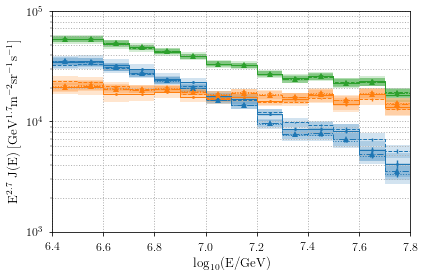

solid_angle = 2.580484743
geom_factor = 0.982962913145


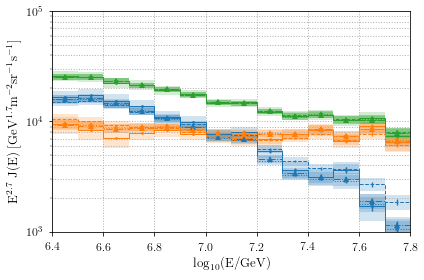

solid_angle = 2.580484743
geom_factor = 0.915975615037


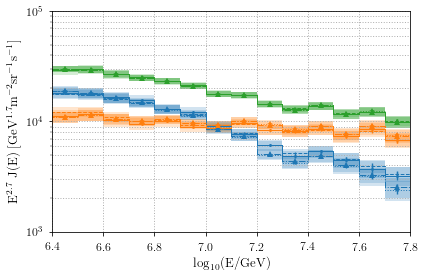

In [55]:
filenames = ['allsky.png', 'dec_lt_median.png', 'dec_gt_median.png']
# filenames = ['dec_lt_median.png', 'dec_gt_median.png', 'allsky.png']
dec_lims = [(-90, -60), (-90, -75), (-75, -60)]

for filename, (dec_min, dec_max) in zip(filenames, dec_lims):
    
    # Solid angle
    theta_max_sim = 40 if config == 'IC79.2010' else 65
    solid_angle = np.pi*np.sin(np.deg2rad(theta_max_sim))**2
    
#     solid_angle = calc_solid_angle(theta_min=theta_min, theta_max=theta_max)
    print('solid_angle = {}'.format(solid_angle))

    theta_min = np.deg2rad(dec_min + 90)
    theta_max = np.deg2rad(dec_max + 90)
    geom_factor = calc_geom_factor(theta_min=theta_min, theta_max=theta_max)
    print('geom_factor = {}'.format(geom_factor))
#     geom_factor = 1

    def counts_to_flux(counts, counts_err=None, composition=None):
        return comp.get_flux(counts, counts_err,
                             energybins=energybins.energy_bins,
                             eff_area=geom_factor * thrown_area,
                             eff_area_err=None,                            
#                              eff_area=geom_factor * eff_area[composition],
#                              eff_area_err=geom_factor * eff_area_err[composition],
                             livetime=livetime,
                             livetime_err=livetime_err,
                             solid_angle=solid_angle,
                             scalingindex=2.7)


    counts_observed = {}
    counts_observed_err = {}

    dec_mask = (df_data['lap_dec'] < np.deg2rad(dec_max)) & (df_data['lap_dec'] > np.deg2rad(dec_min))
#     dec_mask = np.ones(df_data.shape[0], dtype=bool)

    for idx, composition in enumerate(comp_list):
        # Filter out events that don't pass composition & energy mask
        pred_comp_mask = df_data['pred_comp_target'] == idx

        mask = np.logical_and(pred_comp_mask, dec_mask)
    #     df_data = df_data.loc[df_data, :]
    #     print(mask)
    #     print(pred_comp_mask.sum())

        energies = df_data.loc[mask, 'reco_log_energy'].values
        comp_counts, _ = np.histogram(energies,
                                      bins=energybins.log_energy_bins)
        counts_observed[composition] = comp_counts
        counts_observed_err[composition] = np.sqrt(comp_counts)

    counts_observed_err['total'] = np.sqrt(np.sum(counts_observed_err[composition]**2 for composition in comp_list))
    # Calculate total counts
    counts_observed['total'] = np.sum(counts_observed[composition] for composition in comp_list)

    # Format observed counts, detection efficiencies, and priors for PyUnfold use
    counts_pyunfold = np.empty(num_groups * len(energybins.energy_midpoints))
    counts_err_pyunfold = np.empty(num_groups * len(energybins.energy_midpoints))
    for idx, composition in enumerate(comp_list):
        counts_pyunfold[idx::num_groups] = counts_observed[composition]
        counts_err_pyunfold[idx::num_groups] = counts_observed_err[composition]


    # Run unfolding for each of the priors
    names = ['uniform', 'H3a', 'H4a', 'simple_power_law']
    # names = ['Jeffreys', 'H3a', 'H4a', 'Polygonato']
    unfolding_results = {}
    for prior_name in names:
        prior = None if prior_name == 'uniform' else df_priors['{}_prior'.format(prior_name)]
        # priors = 'Jeffreys' if prior_name == 'Jeffreys' else df['{}_prior'.format(prior_name)]
        df_unfolding_iter = pyunfold.iterative_unfold(data=counts_pyunfold,
                                                      data_err=counts_err_pyunfold,
                                                      response=response,
                                                      response_err=response_err,
                                                      efficiencies=efficiencies,
                                                      efficiencies_err=efficiencies_err,
                                                      ts='ks',
                                                      ts_stopping=0.005,
                                                      prior=prior,
                                                      return_iterations=True)
    #                                                   callbacks=[pyunfold.callbacks.SplineRegularizer(degree=3, smooth=1)])
        unfolding_results[prior_name] = df_unfolding_iter



    fig, ax = plt.subplots()
#     fig, ax = plt.subplots(figsize=(10, 5))
    linestyles = ['-', ':', '-.', '--']
    markers = ['.', '*', '^', 'x']
    for prior_name, ls, marker in zip(names, linestyles, markers):
        counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolding_results[prior_name],
                                                                            num_groups=num_groups)
        for composition in comp_list + ['total']:
            flux, flux_sys_err = counts_to_flux(counts=counts[composition],
                                                counts_err=counts_sys_err[composition],
                                                composition=composition)
            flux, flux_stat_err = counts_to_flux(counts=counts[composition],
                                                 counts_err=counts_stat_err[composition],
                                                 composition=composition)
            comp.plot_steps(energybins.log_energy_bins, 
                            flux,
                            yerr=flux_sys_err,
                            color=color_dict[composition],
                            ls=ls,
                            ax=ax)
            label = prior_name.replace('_', ' ') if composition == 'total' else ''
            ax.errorbar(energybins.log_energy_midpoints, flux,
                        yerr=flux_stat_err,
                        color=color_dict[composition],
                        ls='None',
                        marker=marker,
                        label=label)
    ax.set_yscale('log', nonposy='clip')
    ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
    ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
    ax.set_xlim(6.4, 7.8)
    ax.set_ylim(1e3, 1e5)
    ax.grid(lw=1, which='both')
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'allsky.png')
    outfile = os.path.join(comp.paths.figures_dir, 'skymaps', filename)
    # outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'dec_lt_median.png')
    # outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'dec_gt_median.png')
    comp.check_output_dir(outfile)
    plt.savefig(outfile)
    plt.show()

In [88]:
counts

{'heavy': array([6.62507142e+07, 3.62656804e+07, 2.40517378e+07, 1.81806740e+07,
        1.24071377e+07, 7.58876173e+06, 4.72479192e+06, 3.22059638e+06,
        1.98236945e+06, 1.25193017e+06, 9.29216820e+05, 5.47669201e+05,
        3.56300123e+05, 2.49497956e+05, 1.48867167e+05, 1.11860536e+05,
        6.33204506e+04, 4.77479875e+04, 2.67231494e+04]),
 'light': array([7.70526239e+07, 4.87739351e+07, 3.98087118e+07, 2.68979443e+07,
        1.76755150e+07, 1.09997265e+07, 6.80636360e+06, 4.08881679e+06,
        2.48930801e+06, 1.30021666e+06, 7.57987717e+05, 3.96707847e+05,
        2.25206479e+05, 1.62768370e+05, 9.26954245e+04, 5.44617253e+04,
        3.03044190e+04, 1.55066727e+04, 9.57890297e+03]),
 'total': array([1.43303338e+08, 8.50396156e+07, 6.38604496e+07, 4.50786183e+07,
        3.00826527e+07, 1.85884882e+07, 1.15311555e+07, 7.30941316e+06,
        4.47167746e+06, 2.55214683e+06, 1.68720454e+06, 9.44377048e+05,
        5.81506602e+05, 4.12266326e+05, 2.41562591e+05, 1.6632226

## Cosmic-ray flux vs. sky position

In [44]:
import sky_anisotropy as sa

In [230]:
nside = 64
npix = hp.nside2npix(nside)
radius = np.deg2rad(5)

In [231]:
ra = df_data.loc[:, 'lap_ra'].values
dec = df_data.loc[:, 'lap_dec'].values
# Convert from ra/dec equatorial coordinates to the theta/phi coordinates used in healpy
theta, phi = comp.equatorial_to_healpy(ra, dec)

In [232]:
data_skymap = np.zeros(npix)
pix_array = hp.ang2pix(nside, theta, phi)
unique_pix, pix_counts = np.unique(pix_array, return_counts=True)
data_skymap[unique_pix] += pix_counts

In [233]:
df_data['pix'] = pix_array

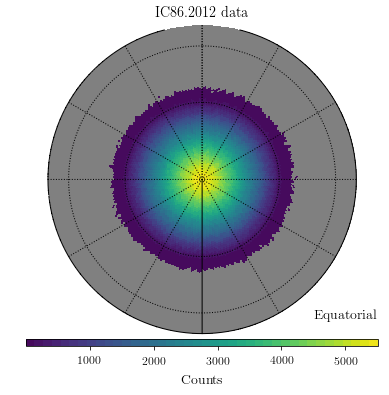

In [234]:
data_skymap[data_skymap == 0] = hp.UNSEEN
comp.plot_skymap(data_skymap, cbar_title='Counts', polar=True)
plt.title('IC86.2012 data')
outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-data-skymap-polar.png'.format(config))
plt.savefig(outfile)
plt.show()

In [235]:
data_skymap = np.zeros(npix)
pix_array = hp.ang2pix(nside, theta, phi)
unique_pix, pix_counts = np.unique(pix_array, return_counts=True)
data_skymap[unique_pix] += pix_counts

In [236]:
ra_test = np.deg2rad(0)
dec_test = np.deg2rad(-60)

n_pix_disc = 22045


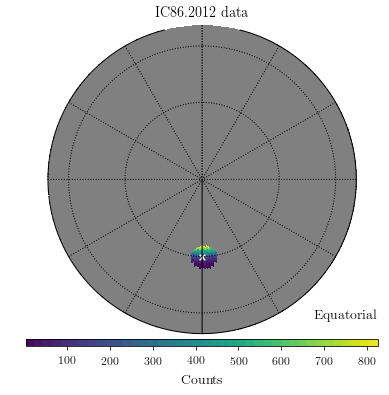

In [203]:
theta_test, phi_test = sa.equatorial_to_healpy(ra_test, dec_test)
vec_test = hp.ang2vec(theta_test, phi_test)
pix_center = hp.ang2pix(nside, theta_test, phi_test)

# ipix = hp.query_disc(nside, vec=vec, radius=radius)
# in_disc = np.isin(np.arange(npix), ipix)

# in_disc = sa.square_on_region(df_data['pix'], pix_center, size=np.deg2rad(5), nside=nside)
# n_pix_square = in_disc.sum()
in_disc = sa.disc_on_region(df_data['pix'], pix_center, size=np.deg2rad(5), nside=nside)
n_pix_disc = in_disc.sum()

print('n_pix_disc = {}'.format(n_pix_disc))
# print('n_pix_square = {}'.format(n_pix_square))
# print('n_pix_disc / n_pix_square = {}'.format(n_pix_disc / n_pix_square))

on_disc_skymap = np.zeros(npix)
pix_array = hp.ang2pix(nside, theta, phi)
unique_pix, pix_counts = np.unique(pix_array[in_disc], return_counts=True)
on_disc_skymap[unique_pix] += pix_counts
# on_disc_skymap = data_skymap.copy()
# on_disc_skymap[~in_disc] = hp.UNSEEN

on_disc_skymap[on_disc_skymap == 0] = hp.UNSEEN
comp.plot_skymap(on_disc_skymap, cbar_title='Counts', polar=True)
hp.projscatter(theta_test, phi_test, color='w', marker='x')
plt.title('IC86.2012 data')
outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-on-disc-skymap-polar.png'.format(config))
plt.savefig(outfile)
plt.show()

In [204]:
off_disc_skymap = data_skymap.copy()
off_disc_skymap[in_disc] = hp.UNSEEN

off_disc_skymap[off_disc_skymap == 0] = hp.UNSEEN
comp.plot_skymap(off_disc_skymap, cbar_title='Counts', polar=True)
hp.projscatter(theta_test, phi_test, color='w', marker='x')
plt.title('IC86.2012 data')
outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}-off-disc-skymap-polar.png'.format(config))
plt.savefig(outfile)
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 49152 but corresponding boolean dimension is 6668215

In [56]:
theta, phi = sa.equatorial_to_healpy(df_data.loc[:, 'lap_ra'].values,
                                     df_data.loc[:, 'lap_dec'].values)
pix_idx = hp.ang2pix(nside=nside, theta=theta, phi=phi)
in_disc = np.isin(pix_idx, ipix)

# ebins = np.arange(6.4, 7.9, 0.1)
ebins = np.arange(6.4, 7.5, 0.1)
ebins = np.concatenate([ebins, [7.8]])

energies_in_disc = df_data.loc[in_disc, 'reco_log_energy'].values
counts_in_disc, _ = np.histogram(energies_in_disc, bins=ebins) 
print('counts_in_disc = {}'.format(counts_in_disc))

energies_outside_disc = df_data.loc[~in_disc, 'reco_log_energy'].values
counts_outside_disc, _ = np.histogram(energies_outside_disc, bins=ebins)
print('counts_outside_disc = {}'.format(counts_outside_disc))

NameError: name 'ipix' is not defined

In [53]:
ebins

array([6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.8])

In [41]:
assert counts_in_disc.shape == counts_outside_disc.shape

alpha = np.sum(counts_in_disc) / np.sum(counts_outside_disc)
print('alpha = {}'.format(alpha))
expected = alpha * counts_outside_disc
# expected = 1 * counts_outside_disc

# assert np.allclose(counts_in_disc.sum(), expected.sum())

chi_squared_likelihood = 2 * np.sum(expected - counts_in_disc + (counts_in_disc * np.log(counts_in_disc / expected)))
print('chi_squared_likelihood = {}'.format(chi_squared_likelihood))

chi_squared_on = np.sum((counts_in_disc - expected)**2 / counts_in_disc)
print('chi_squared_on = {}'.format(chi_squared_on))

chi_squared_off = np.sum((counts_in_disc - expected)**2 / expected)
print('chi_squared_off = {}'.format(chi_squared_off))

alpha = 0.0540830730344
chi_squared_likelihood = 430.818468803
chi_squared_on = 420.90663922
chi_squared_off = 437.092560618


In [44]:
# in_energy_range = np.logical_and(energybins.log_energy_midpoints <= 7.8,
#                                  energybins.log_energy_midpoints >= 6.4)

# fig, ax = plt.subplots()
# ax.errorbar(energybins.log_energy_midpoints[in_energy_range], counts_in_disc,
#             yerr=np.sqrt(counts_in_disc),
#             label='Inside disc (on)')
# alpha = np.sum(counts_in_disc) / np.sum(counts_outside_disc)
# expected = alpha * counts_outside_disc
# ax.errorbar(energybins.log_energy_midpoints[in_energy_range], expected,
#             yerr=np.sqrt(expected),
#             label='Outside disc (off)')
# ax.set_yscale('log', nonposy='clip')
# ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
# ax.set_ylabel('Counts')
# ax.set_title('(ra, dec) = ({:0.2f}, {:0.2f})'.format(np.rad2deg(ra_test), np.rad2deg(dec_test)))
# # ax.set_title('$\mathrm{\\chi^2 / d.o.f} = $ '+'{:0.2f}'.format(test_chi2))

# likelihood_str = '$\mathrm{\chi^2_{likelihood}}$' + ' = {:0.1f}'.format(chi_squared_likelihood)
# on_str = '$\mathrm{\chi^2_{on}}$' + ' = {:0.1f}'.format(chi_squared_on)
# off_str = '$\mathrm{\chi^2_{off}}$' + ' = {:0.1f}'.format(chi_squared_off)
# title = '\n'.join([likelihood_str, on_str, off_str])

# # ax.annotate(title, (7.45, 1e4))

# ax.set_xlim(6.4, 7.8)
# ax.grid()
# ax.legend()
# outfile = os.path.join(comp.paths.figures_dir,
#                        'skymaps',
#                        '{}-energy-dist-comparison.png'.format(config))
# # plt.savefig(outfile)
# plt.show()

In [237]:
theta, phi = hp.pix2ang(nside, list(range(npix)))
ra, dec = sa.healpy_to_equatorial(theta, phi)
# has_data = dec < df_data.loc[:, 'lap_dec'].max()
has_data = dec < np.deg2rad(-60)
# has_data = dec < np.deg2rad(-75)
# has_data = dec < np.deg2rad(-80)
# has_data = dec < np.deg2rad(-88)

size = np.deg2rad(5)
print('size = {:0.2f} [deg]'.format(np.rad2deg(size)))

# has_data = has_data & (dec > np.deg2rad(-90) + size)

has_data.sum()

size = 5.00 [deg]


3280

In [238]:
energy_range_mask = (df_data['reco_log_energy'] >= 6.1) & (df_data['reco_log_energy'] <= 8.0)

In [239]:
ebins = np.arange(6.4, 7.9, 0.1)
# ebins = np.arange(6.4, 7.5, 0.1)
# ebins = np.concatenate([ebins, [7.8]])

s125_bins = np.linspace(0.5, 1.6, 15)

on_region = 'disc'
# on_region = 'square'
print('on_region = {}'.format(on_region))
off_region = 'allsky'
# off_region = 'theta_band'
# off_region = 'opposite'
print('off_region = {}'.format(off_region))

# key = 'log_s125'
key = 'reco_log_energy'
print('key = {}'.format(key))

on_region = disc
off_region = allsky
key = reco_log_energy


In [76]:
dec_bins = np.deg2rad(np.linspace(-90, -50, 3, endpoint=True))
dec_bins

array([-1.57079633, -1.22173048, -0.87266463])

In [77]:
df_data.loc[energy_range_mask, [key, 'pred_comp_target']].values

array([[6.34235091, 1.        ],
       [6.2167316 , 0.        ],
       [6.38275612, 1.        ],
       ...,
       [6.59969884, 1.        ],
       [6.20906215, 1.        ],
       [6.80435173, 1.        ]])

In [78]:
def hist_func(x):
    return x.sum(axis=1)

In [79]:
efficiencies, efficiencies_err

(array([0.00711621, 0.00640114, 0.00792564, 0.00747336, 0.00837118,
        0.00800932, 0.00860879, 0.00827434, 0.00873487, 0.00842553,
        0.00880808, 0.00853552, 0.00885811, 0.00862577, 0.00889926,
        0.00871167, 0.00893319, 0.00879576, 0.00896376, 0.0088786 ,
        0.00899596, 0.00896131, 0.00902511, 0.00904439, 0.00905524,
        0.00912615, 0.00908302, 0.00920706, 0.00911336, 0.00928806,
        0.00914197, 0.00936856, 0.00917137, 0.00944958, 0.009201  ,
        0.00953194, 0.00922881, 0.00961275]),
 array([8.29777304e-05, 8.57625303e-05, 7.19382946e-05, 6.61293346e-05,
        6.54059105e-05, 6.52014986e-05, 7.09442272e-05, 6.84265813e-05,
        7.21341016e-05, 6.63914450e-05, 6.73062362e-05, 6.36186618e-05,
        6.30139937e-05, 5.42168561e-05, 5.99604535e-05, 5.08409622e-05,
        5.59194423e-05, 5.19360400e-05, 5.26195131e-05, 5.36111009e-05,
        5.78031878e-05, 5.78163099e-05, 5.92420408e-05, 6.35894786e-05,
        6.49120809e-05, 6.90722998e-05, 7.0901

In [158]:
eff = np.load('efficienies.npy')
eff_err = np.load('efficienies_err.npy')
eff.reshape(-1)

array([0.00711648, 0.00639353, 0.00792472, 0.00747015, 0.00837055,
       0.00800534, 0.00860573, 0.00827011, 0.00873291, 0.00842231,
       0.00880792, 0.00853085, 0.0088584 , 0.00862292, 0.00889751,
       0.00870882, 0.00893136, 0.00879243, 0.00896279, 0.00887518,
       0.0089931 , 0.00895761, 0.00902289, 0.00903992, 0.00905245,
       0.00912219, 0.0090819 , 0.00920444, 0.0091113 , 0.00928668,
       0.00914067, 0.00936892, 0.00917003, 0.00945116, 0.00919939,
       0.0095334 , 0.00922875, 0.00961564])

In [164]:
response, response_err = comp.response_matrix(true_energy=log_true_energy_sim_test,
                                              reco_energy=log_reco_energy_sim_test,
                                              true_target=true_target,
                                              pred_target=pred_target,
                                              efficiencies=eff.reshape(-1),
                                              efficiencies_err=eff_err.reshape(-1),
                                              energy_bins=energybins.log_energy_bins)

In [165]:
np.testing.assert_allclose(response.sum(axis=0), eff.reshape(-1))

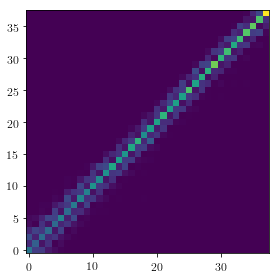

In [166]:
plt.imshow(response, origin='lower')

In [52]:
unfolding_energy_range_mask = np.logical_and(energybins.log_energy_midpoints >= 6.4,
                                             energybins.log_energy_midpoints <= 7.8)

In [54]:
def unfolding_func(counts):
    original_shape = counts.shape
    counts_err = np.sqrt(counts)
    unfolded_results = pyunfold.iterative_unfold(data=counts.reshape(-1),
                                                 data_err=counts_err.reshape(-1),
                                                 response=response,
                                                 response_err=response_err,
                                                 efficiencies=efficiencies.reshape(-1),
                                                 efficiencies_err=efficiencies_err.reshape(-1),
                                                 ts='ks',
                                                 ts_stopping=0.01,
                                                 return_iterations=True,
#                                                  callbacks=pyunfold.Logger()
                                                )
#     print(unfolded_results)
#     unfolded = unfolded_results['unfolded']
    counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolded_results,
                                                                        num_groups=num_groups)
#     print(unfolded.reshape(original_shape)[unfolding_energy_range_mask])
#     return unfolded.reshape(original_shape)[unfolding_energy_range_mask].sum(axis=1)

    eff_total = df_eff['eff_median_total'].values[unfolding_energy_range_mask]
    
    counts = counts['total'][unfolding_energy_range_mask] / eff_total
    counts_err = counts_sys_err['total'][unfolding_energy_range_mask] / eff_total

    return counts, counts_err

In [55]:
energybins.log_energy_midpoints

array([6.15, 6.25, 6.35, 6.45, 6.55, 6.65, 6.75, 6.85, 6.95, 7.05, 7.15,
       7.25, 7.35, 7.45, 7.55, 7.65, 7.75, 7.85, 7.95])

In [56]:
unfolding_energy_range_mask

array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False])

In [57]:
energy_comp_bins = comp.get_bins(config=config, num_groups=2)
# energy_comp_bins[0] = energy_comp_bins[0][3:-2]
energy_comp_bins

[array([6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3,
        7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ]), array([0, 1, 2])]

In [58]:
energy_comp_bins[0]

array([6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3,
       7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ])

In [59]:
energy_comp_bins[0][3:-2]

array([6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6,
       7.7, 7.8])

In [60]:
energy_comp_bins

[array([6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3,
        7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ]), array([0, 1, 2])]

In [92]:
c, _ = np.histogramdd(df_data.loc[:, ['reco_log_energy', 'pred_comp_target']].values, bins=energy_comp_bins)
c

array([[9.44957e+05, 7.51526e+05],
       [8.77673e+05, 6.99730e+05],
       [6.05615e+05, 5.26746e+05],
       [4.35386e+05, 3.43818e+05],
       [2.96770e+05, 2.19852e+05],
       [1.96104e+05, 1.37759e+05],
       [1.10422e+05, 9.93680e+04],
       [7.20010e+04, 5.71130e+04],
       [4.36660e+04, 3.45300e+04],
       [2.20760e+04, 2.50400e+04],
       [1.44320e+04, 1.44290e+04],
       [7.83900e+03, 9.94300e+03],
       [4.49200e+03, 6.75100e+03],
       [2.77700e+03, 4.31500e+03],
       [1.65400e+03, 2.98600e+03],
       [8.65000e+02, 2.03900e+03],
       [5.31000e+02, 1.29000e+03],
       [3.62000e+02, 7.95000e+02],
       [2.03000e+02, 5.99000e+02]])

In [99]:
c_shape = c.shape
unfolded_results = pyunfold.iterative_unfold(data=c.reshape(-1),
                                             data_err=c.reshape(-1),
                                             response=response,
                                             response_err=response_err,
                                             efficiencies=efficiencies.reshape(-1),
                                             efficiencies_err=efficiencies_err.reshape(-1),
                                             ts='ks',
                                             ts_stopping=0.01,
                                             return_iterations=True,
                                             callbacks=pyunfold.Logger())

Iteration 1: ts = 0.6100, ts_stopping = 0.01
Iteration 2: ts = 0.0444, ts_stopping = 0.01
Iteration 3: ts = 0.0162, ts_stopping = 0.01
Iteration 4: ts = 0.0097, ts_stopping = 0.01


In [100]:
unfolded_results

,num_iterations,stat_err,sys_err,ts_iter,ts_stopping,unfolded
0,1,"[72144060.5539402, 65263651.468855485, 4939159...","[9260598.502860475, 9260451.954531727, 6047797...",0.609956,0.01,"[122256006.86924757, 118236547.14915477, 10095..."
1,2,"[110172338.16200663, 96591482.34649698, 649492...","[14540329.181402853, 14505296.89321703, 831131...",0.044443,0.01,"[141462877.96656603, 133608476.85272926, 10694..."
2,3,"[136007465.61649355, 119147582.6842352, 788618...","[18470628.938835535, 18451994.46890841, 101028...",0.016188,0.01,"[149952668.24413016, 139399778.8103174, 107243..."
3,4,"[157758072.15801272, 139035507.63523868, 91851...","[21756871.75994542, 21806682.48076413, 1175591...",0.009716,0.01,"[155105714.47073385, 142780131.99427956, 10656..."


In [101]:
counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolded_results,
                                                                    num_groups=num_groups)
counts

{'heavy': array([1.42780132e+08, 8.19576562e+07, 5.01552462e+07, 3.48210577e+07,
        2.33715443e+07, 1.41525433e+07, 9.05747716e+06, 6.18954766e+06,
        3.73280514e+06, 2.38509106e+06, 1.65700170e+06, 1.02448150e+06,
        7.24417517e+05, 5.11601409e+05, 3.01854100e+05, 2.32379029e+05,
        1.27258209e+05, 9.47463201e+04, 5.77088332e+04]),
 'light': array([1.55105714e+08, 1.06566543e+08, 7.64276121e+07, 5.05317203e+07,
        3.49518159e+07, 2.21007515e+07, 1.37153312e+07, 7.84634774e+06,
        4.89284370e+06, 2.64138672e+06, 1.57388165e+06, 8.38666820e+05,
        4.26289476e+05, 2.82155681e+05, 1.76665236e+05, 9.31184983e+04,
        4.67541565e+04, 2.71273641e+04, 1.92186823e+04]),
 'total': array([2.97885846e+08, 1.88524199e+08, 1.26582858e+08, 8.53527781e+07,
        5.83233602e+07, 3.62532948e+07, 2.27728084e+07, 1.40358954e+07,
        8.62564883e+06, 5.02647778e+06, 3.23088335e+06, 1.86314832e+06,
        1.15070699e+06, 7.93757091e+05, 4.78519337e+05, 3.2549752

In [204]:
def counts_to_flux(counts, counts_err=None, composition=None):
    return comp.get_flux(counts, counts_err,
                         energybins=energybins.energy_bins,
                         eff_area=thrown_area,
#                          eff_area=geom_factor * thrown_area,
                         eff_area_err=None,                            
#                              eff_area=geom_factor * eff_area[composition],
#                              eff_area_err=geom_factor * eff_area_err[composition],
                         livetime=livetime,
                         livetime_err=livetime_err,
                         solid_angle=solid_angle,
                         scalingindex=2.7)

In [221]:
unfolded_err = unfolded_results['stat_err'].reshape(c_shape)
unfolded_err

array([[1.91785034e+08, 1.64363918e+08],
       [9.65102288e+07, 7.62024645e+07],
       [7.83126921e+07, 5.66765975e+07],
       [5.27301723e+07, 3.88060493e+07],
       [4.16657475e+07, 2.74987447e+07],
       [2.77989062e+07, 1.81228861e+07],
       [1.62761629e+07, 1.26755588e+07],
       [1.00017004e+07, 7.95538018e+06],
       [6.55718913e+06, 5.35622026e+06],
       [2.92628875e+06, 3.17312300e+06],
       [2.03729344e+06, 2.19840475e+06],
       [1.02733366e+06, 1.35067847e+06],
       [5.64279443e+05, 1.01004526e+06],
       [3.47550012e+05, 6.64206744e+05],
       [2.40858616e+05, 4.52939795e+05],
       [1.19665254e+05, 3.17960126e+05],
       [6.88879301e+04, 1.92893427e+05],
       [3.36896519e+04, 1.19889391e+05],
       [3.55206632e+04, 2.08913471e+05]])

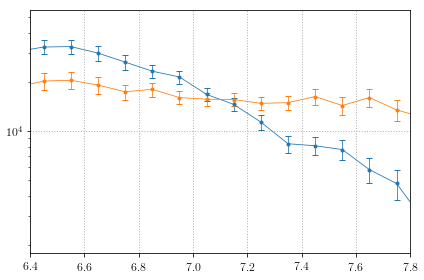

In [218]:
fig, ax = plt.subplots()
unfolded = unfolded_results['unfolded'].reshape(c_shape)
unfolded_err = unfolded_results['sys_err'].reshape(c_shape)
for comp_idx, composition in enumerate(comp_list):
    counts = unfolded[:, comp_idx]
    counts_err = unfolded_err[:, comp_idx]
    flux, flux_err = counts_to_flux(counts, counts_err)
    plt.errorbar(energybins.log_energy_midpoints,
                 flux,
                 yerr=flux_err,
                 color=color_dict[composition])
    
# counts_total = unfolded.sum(axis=1)

# plt.errorbar(energybins.log_energy_midpoints[unfolding_energy_range_mask],
#              unfolded[unfolding_energy_range_mask, :].sum(axis=1), 
#              yerr=unfolded_err[unfolding_energy_range_mask, :].sum(axis=1),
#              color=color_dict['total'])

ax.set_yscale('log', nonposy='clip')
ax.set_xlim(6.4, 7.8)
ax.grid()
plt.show()

In [104]:
pix_max_sig

48845

In [61]:
sa.core.on_off_chi_squared_single(samples=df_data.loc[energy_range_mask, ['reco_log_energy', 'pred_comp_target']].values,
                                  pix=df_data.loc[energy_range_mask, 'pix'].values,
                                  pix_center=pix_disc[0],
                                  on_region=on_region,
                                  size=size,
                                  off_region=off_region,
                                  bins=energy_comp_bins,
                                  nside=nside,
                                  hist_func=unfolding_func)

NameError: name 'pix_disc' is not defined

In [64]:
from sky_anisotropy.core import on_off_chi_squared_single

counts_on_test, counts_on_err_test, counts_off_test, counts_off_err_test = sa.on_off_distributions(
                          samples=df_data.loc[energy_range_mask, ['reco_log_energy', 'pred_comp_target']].values,
                          pix=df_data.loc[energy_range_mask, 'pix'].values,
                          pix_center=pix_disc[0],
                          on_region=on_region,
                          size=size,
                          off_region=off_region,
                          bins=energy_comp_bins,
                          nside=nside,
                          hist_func=unfolding_func)
#                           hist_func=hist_func)

In [65]:
counts_on_test.shape

(14,)

In [66]:
energy_comp_bins[0][:-1].shape

(19,)

In [67]:
counts_on_test.shape

(14,)

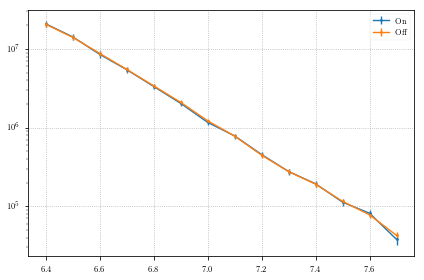

In [70]:
unfolded_counts_on_test = counts_on_test
unfolded_counts_on_err_test = counts_on_err_test
unfolded_counts_off_test = counts_off_test
unfolded_counts_off_err_test = counts_off_err_test

alpha = np.sum(unfolded_counts_on_test) / np.sum(unfolded_counts_off_test)
scaled_unfolded_counts_off_test = alpha * unfolded_counts_off_test
scaled_unfolded_counts_off_err_test = alpha * unfolded_counts_off_err_test

fig, ax = plt.subplots()
ax.errorbar(energy_comp_bins[0][:-1][unfolding_energy_range_mask],
            unfolded_counts_on_test,
            unfolded_counts_on_err_test,
            label='On',
            color='C0')
ax.errorbar(energy_comp_bins[0][:-1][unfolding_energy_range_mask],
            scaled_unfolded_counts_off_test,
            scaled_unfolded_counts_off_err_test,
            label='Off',
            color='C1')
# comp.plot_steps(energy_comp_bins[0][unfolding_energy_range_mask], scaled_counts_off_test, np.sqrt(scaled_counts_off_test), label='Off', color='C1', ax=ax)
ax.set_yscale('log', nonposy='clip')
ax.grid()
ax.legend()
plt.show()

In [139]:
sa.core.counts_chi_squared(unfolded_counts_on_test, scaled_unfolded_counts_off_test)

2314.8055282815576

In [240]:
pix_disc = np.arange(npix)[has_data]
pix_disc.shape

(3280,)

In [241]:
num_workers = min(len(pix_disc), 35)
with dask.config.set(scheduler='threads', num_workers=num_workers) as _, ProgressBar() as pbar:
    samples = df_data.loc[:, [key]].values
    pix = df_data.loc[:, 'pix'].values
    results = sa.on_off_chi_squared(
#                                     samples=df_data.loc[:, ['reco_log_energy', 'pred_comp_target']].values,
                                    samples=samples,
                                    pix=pix,
                                    pix_center=pix_disc,
                                    on_region=on_region,
                                    size=size,
                                    off_region=off_region,
                                    bins=ebins, 
#                                     bins=energy_comp_bins,
                                    nside=nside,
#                                     hist_func=unfolding_func,
                                    )

[########################################] | 100% Completed | 17min 17.8s
[########################################] | 100% Completed |  0.1s


In [243]:
results.head()

,alpha,chi2,ndof,num_on,pix_center,pval,sig
0,0.005139,160.026407,14,10942.0,45872,7.010273e-27,10.670279
1,0.005282,149.515460,14,11246.0,45873,8.985345e-25,10.209544
2,0.005505,158.245975,14,11718.0,45874,1.598020e-26,10.593446
3,0.005498,142.960704,14,11703.0,45875,1.827060e-23,9.913025
4,0.005277,130.716993,14,11234.0,45876,4.906272e-21,9.338049


In [244]:
output_hdf = os.path.join(os.getcwd(),
                          'results',
                          '{}_energy'.format(energy_pipeline_name),
                          'chi2-results-{}-on-{}-off-{:0.0f}deg-size.hdf'.format(on_region, off_region, np.rad2deg(size)))
print('output_hdf = {}'.format(output_hdf))
comp.check_output_dir(output_hdf)
results.to_hdf(output_hdf, 'dataframe', format='table')

output_hdf = /home/jbourbeau/cr-composition/skymap/results/RF_energy/chi2-results-disc-on-allsky-off-5deg-size.hdf
The directory /home/jbourbeau/cr-composition/skymap/results/RF_energy doesn't exist. Creating it...


In [245]:
# input_hdf = os.path.join(os.getcwd(), 'data', 'chi2-results-radius-{:0.1f}-degree.hdf'.format(np.rad2deg(radius)))
# input_hdf = os.path.join(os.getcwd(),
#                          'results',
#                          key,
#                          'chi2-results-{}-on-{}-off-{:0.0f}deg-size.hdf'.format(on_region, off_region, np.rad2deg(size)))
# results = pd.read_hdf(input_hdf)

In [246]:
from scipy import stats

In [247]:
theta_center, phi_center = hp.pix2ang(nside=nside, ipix=results['pix_center'].values)
ra_center, dec_center = sa.healpy_to_equatorial(theta_center, phi_center)
dec_center

array([-1.05477994, -1.05477994, -1.05477994, ..., -1.55803848,
       -1.55803848, -1.55803848])

In [248]:
dec_mask = dec_center < np.deg2rad(-65)
dec_mask

array([False, False, False, ...,  True,  True,  True])

The directory /home/jbourbeau/public_html/figures/composition/skymaps/RF_energy/chi2-results-disc-on-allsky-off-5deg-size doesn't exist. Creating it...


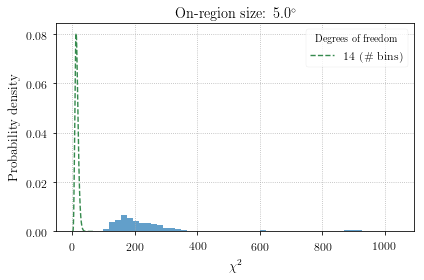

In [249]:
fig, ax = plt.subplots()
hist_params = {'bins': 50,
#                'histtype': 'step',
               'alpha': 0.7,
               }
ax.hist(results.loc[dec_mask, 'chi2'].values, density=True, **hist_params)

# Include chi-squared PDF for various degrees of freedom
x = np.linspace(0, 70, 200)
num_bins = len(ebins) - 1
for dof, label, color, ls in zip([num_bins - 1, num_bins, num_bins + 1, num_bins + 2],
                                 ['\# bins - 1', '\# bins', '\# bins + 1', '\# bins + 2'],
                                 sns.color_palette('Greens_d', 4).as_hex(),
                                 ['-', '--', '-.', ':']):
    
    if dof != num_bins:
        continue

    chi2_pdf = stats.chi2.pdf(x, dof)
    ax.plot(x, chi2_pdf,
            marker='None',
            ls=ls,
            color=color,
            label='{} ({})'.format(dof, label))

ax.set_xlabel('$\\chi^2$')
ax.set_ylabel('Probability density')
ax.set_title('On-region size: {:0.1f}'.format(np.rad2deg(size)) + '$^{\circ}$')
ax.grid()
ax.legend(title='Degrees of freedom')

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'chi2-results-{}-on-{}-off-{:0.0f}deg-size'.format(on_region, off_region, np.rad2deg(size)),
                       '{}-chi2-calc-comparison.png'.format(config))
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

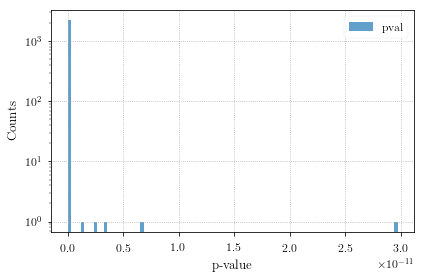

In [250]:
fig, ax = plt.subplots()
hist_params = {'bins': 100,
#                'histtype': 'step',
               'alpha': 0.7,
               }
ax.hist(results.loc[dec_mask, 'pval'], **hist_params)
ax.set_xlabel('p-value')
ax.set_ylabel('Counts')
ax.set_yscale('log', nonposy='clip')
ax.grid()
ax.legend()

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'chi2-results-{}-on-{}-off-{:0.0f}deg-size'.format(on_region, off_region, np.rad2deg(size)),
                       '{}-pval-hist.png'.format(config))
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


inf


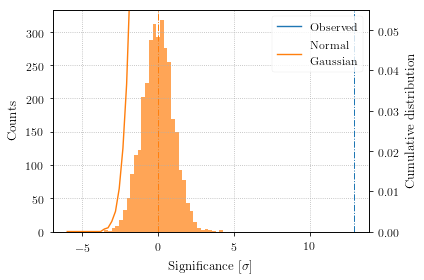

In [251]:
from scipy.special import erfcinv

fig, ax = plt.subplots()
bins = np.linspace(-6, 6, 50)
hist_params = {'bins': bins,
#                'histtype': 'step',
               'alpha': 0.7,
               }

theta, phi = hp.pix2ang(nside, results['pix_center'])
ra, dec = sa.healpy_to_equatorial(theta, phi)

# sig = results.loc[:, 'sig']
sig = results.loc[dec > np.deg2rad(-90) + size, 'sig']

ax.hist(sig, **hist_params)
ax.axvline(sig.median(),
           marker='None', ls='-.', lw=1,
           label='Median')

counts, _ = np.histogram(sig, bins=bins)
counts = counts / counts.sum()
ax_cdf = ax.twinx()
ax_cdf.plot(bins[:-1], np.cumsum(counts), marker='None',
            label='Observed')
ax_cdf.set_ylabel('Cumulative distribution')
ax_cdf.set_ylim(bottom=0)

np.random.seed(2)
# normal_samples = np.random.normal(size=int(1e6))
normal_samples = np.random.normal(size=len(sig))
ax.axvline(np.median(normal_samples),
           marker='None', ls='-.', lw=1,
           label='Median', color='C1')
ax.hist(normal_samples, **hist_params)
counts, _ = np.histogram(normal_samples, bins=bins)
counts = counts / counts.sum()
ax_cdf.plot(bins[:-1], np.cumsum(counts), marker='None',
            label='Normal \n Gaussian' )


d, ks_pval = stats.ks_2samp(normal_samples, sig.values)
print(erfcinv(2 * ks_pval) * np.sqrt(2))


ax.set_xlabel('Significance [$\\sigma$]')
ax.set_ylabel('Counts')
ax.grid()
ax_cdf.legend()

# outfile = os.path.join(comp.paths.figures_dir,
#                        'skymaps',
#                        'radius-{}-degrees'.format(np.rad2deg(size)),
#                        '{}-significance-dist.png'.format(config))

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'chi2-results-{}-on-{}-off-{:0.0f}deg-size'.format(on_region, off_region, np.rad2deg(size)),
                        '{}-significance-dist.png'.format(config))
plt.savefig(outfile)

plt.show()

Save map to disk

In [252]:
# hp.write_map('chi-squared-map.fits', chi2_map, dtype=chi2_map.dtype, coord='C')

In [253]:
# chi2_map = hp.read_map('chi-squared-map.fits')

The directory /home/jbourbeau/public_html/figures/composition/skymaps/RF_energy/radius-5.0-degrees doesn't exist. Creating it...


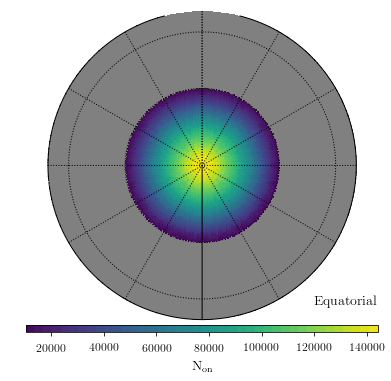

In [254]:
num_on_map = np.full(npix, hp.UNSEEN)
# chi2_map = np.zeros(npix)
# chi2_map[pix_idxs] = chi_squared
num_on_map[results['pix_center']] = results['num_on']

theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = sa.healpy_to_equatorial(theta, phi)
# num_on_map[dec < np.deg2rad(-90) + size] = hp.UNSEEN

comp.plot_skymap(num_on_map, cbar_title='$\mathrm{N_{on}}$', polar=True)
# theta, phi = hp.pix2ang(nside=nside, ipix=pix_idxs)
# hp.projscatter(theta, phi, c=chi2)

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'radius-{}-degrees'.format(np.rad2deg(size)),
                       '{}-num-on-skymap-polar.png'.format(config))
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

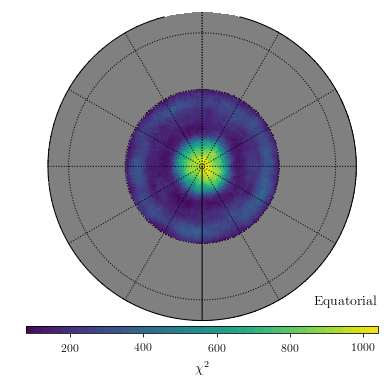

In [258]:
chi2_map = np.full(npix, hp.UNSEEN)
# chi2_map = np.zeros(npix)
# chi2_map[pix_idxs] = chi_squared
chi2_map[results['pix_center']] = results['chi2']

theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = sa.healpy_to_equatorial(theta, phi)
# chi2_map[dec > np.deg2rad(-65)] = hp.UNSEEN
# chi2_map[dec < np.deg2rad(-90) + size] = hp.UNSEEN

comp.plot_skymap(chi2_map, cbar_title='$\mathrm{\chi^2}$', polar=True)
# theta, phi = hp.pix2ang(nside=nside, ipix=pix_idxs)
# hp.projscatter(theta, phi, c=chi2)

# outfile = os.path.join(comp.paths.figures_dir,
#                        'skymaps',
#                        'radius-{}-degrees'.format(np.rad2deg(size)),
#                        '{}-chi2-skymap-polar.png'.format(config))

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'chi2-results-{}-on-{}-off-{:0.0f}deg-size'.format(on_region, off_region, np.rad2deg(size)),
                       '{}-chi2-skymap-polar.png'.format(config))
plt.savefig(outfile)

plt.show()

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


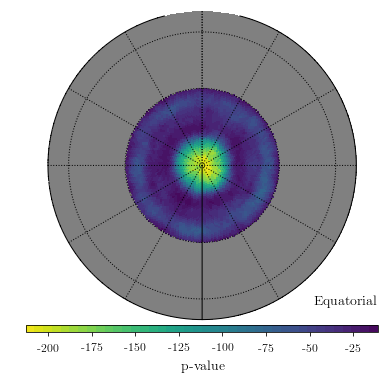

In [259]:
pval_map = np.full(npix, hp.UNSEEN)
pval_map[results['pix_center']] = results['pval']

theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = sa.healpy_to_equatorial(theta, phi)
# pval_map[dec > np.deg2rad(-65)] = hp.UNSEEN
# pval_map[dec < np.deg2rad(-90) + size] = hp.UNSEEN

comp.plot_skymap(np.log10(pval_map), cbar_title='p-value', polar=True, color_palette='viridis_r')
# comp.plot_skymap(pval_map, cbar_title='p-value', polar=True, color_palette='viridis_r')

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'chi2-results-{}-on-{}-off-{:0.0f}deg-size'.format(on_region, off_region, np.rad2deg(size)),
                       '{}-pval-skymap-polar.png'.format(config))
plt.savefig(outfile)

plt.show()

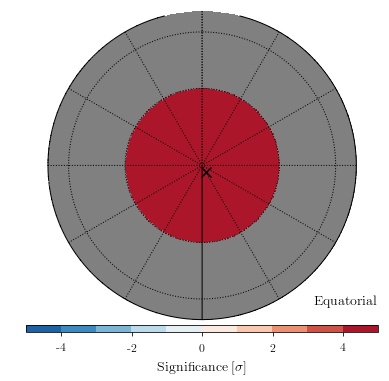

In [260]:
sig_map = np.full(npix, hp.UNSEEN)
sig_map[results['pix_center']] = results['sig']

theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = sa.healpy_to_equatorial(theta, phi)
# sig_map[dec > np.deg2rad(-65)] = hp.UNSEEN
# sig_map[dec < np.deg2rad(-90) + np.deg2rad(r)] = hp.UNSEEN

comp.plot_skymap(sig_map,
                 color_palette='RdBu_r',
                 cbar_min=-5,
                 cbar_max=5,
                 color_bins=10,
                 cbar_title='Significance [$\sigma$]',
                 polar=True)


pix_max_sig = results.loc[results.sig.idxmax(), 'pix_center']
theta_max, phi_max = hp.pix2ang(nside=nside, ipix=pix_max_sig)

hp.projscatter(theta_max, phi_max, marker='x', s=100, c='k')

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'chi2-results-{}-on-{}-off-{:0.0f}deg-size'.format(on_region, off_region, np.rad2deg(size)),
                       '{}-sig-skymap-polar.png'.format(config))
plt.savefig(outfile)

plt.show()

In [261]:
results.loc[dec_mask, 'sig'].min(), results.loc[dec_mask, 'sig'].max()

(6.54520760422551, 31.156497064561556)

In [187]:
pix_max_sig = results.loc[results.sig.idxmax(), 'pix_center']
theta_max, phi_max = hp.pix2ang(nside=nside, ipix=pix_max_sig)


samples = df_data.loc[:, [key]].values
pix = df_data.loc[:, 'pix'].values
counts_on_max, counts_on_err_max, counts_off_max, counts_off_err_max = sa.on_off_distributions(samples=samples,
                                pix=pix,
                                pix_center=pix_max_sig,
                                on_region=on_region,
                                size=size,
                                off_region=off_region,
                                bins=ebins, 
                                nside=nside)

In [188]:
ebins_midpoints = (ebins[:-1] + ebins[1:]) / 2
ebins_midpoints

array([6.45, 6.55, 6.65, 6.75, 6.85, 6.95, 7.05, 7.15, 7.25, 7.35, 7.45,
       7.55, 7.65, 7.75])

In [189]:
ebins

array([6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6,
       7.7, 7.8])

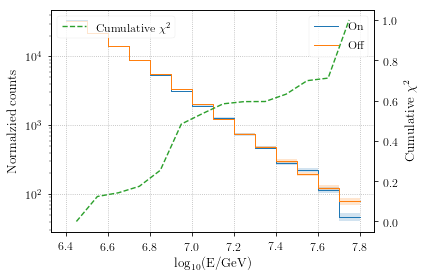

In [209]:
alpha = np.sum(counts_on_max) / np.sum(counts_off_max)
scaled_counts_off_max = alpha * counts_off_max

fig, ax = plt.subplots()
comp.plot_steps(ebins, counts_on_max, np.sqrt(counts_on_max), label='On', color='C0', ax=ax)
comp.plot_steps(ebins, scaled_counts_off_max, np.sqrt(scaled_counts_off_max), label='Off', color='C1', ax=ax)

chi2_max = results.loc[results.sig.idxmax(), 'chi2']
cumulative_chi2 = []
for stop_idx in range(1, len(counts_on_max) + 1):
    # stop_idx = -4
    c = sa.core.counts_chi_squared(counts_on_max[:stop_idx],
                                   scaled_counts_off_max[:stop_idx] * (counts_on_max[:stop_idx].sum() / scaled_counts_off_max[:stop_idx].sum())
                                  )
    cumulative_chi2.append(c / chi2_max)
    
ax2 = ax.twinx()
ax2.plot(ebins_midpoints, cumulative_chi2,
         marker='None',
         ls='--',
         color='C2',
         label='Cumulative $\mathrm{\chi^2}$')
ax2.set_ylabel('Cumulative $\mathrm{\chi^2}$')
ax2.legend()

ax.set_ylabel('Normalzied counts')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_yscale('log', nonposy='clip')
ax.grid()
ax.legend()

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       '{}_energy'.format(energy_pipeline_name),
                       'chi2-results-{}-on-{}-off-{:0.0f}deg-size'.format(on_region, off_region, np.rad2deg(size)),
                       '{}-max-sig-energy-dist.png'.format(config))
plt.savefig(outfile)

plt.show()

In [79]:
results.chi2.max()

75.16138679532881

In [80]:
sa.core.counts_chi_squared(counts_on_max, scaled_counts_off_max)

75.16138679532881

In [148]:
ebins_midpoints.shape, len(cumulative_chi2)

((14,), 13)

In [149]:
cumulative_chi2 = []
for stop_idx in range(1, len(counts_on_max) + 1):
    # stop_idx = -4
    c = sa.core.counts_chi_squared(counts_on_max[:stop_idx],
                                   scaled_counts_off_max[:stop_idx] * (counts_on_max[:stop_idx].sum() / scaled_counts_off_max[:stop_idx].sum())
                                  )
    cumulative_chi2.append(c)

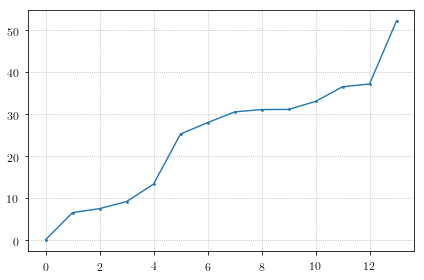

In [150]:
plt.plot(cumulative_chi2)
plt.grid()
plt.show()

In [127]:
for r in [3.0, 4.0, 5.0]:
    input_hdf = os.path.join(os.getcwd(), 'data', 'chi2-results-radius-{:0.1f}-degree.hdf'.format(r))
    results = pd.read_hdf(input_hdf)

    sig_map = np.full(npix, hp.UNSEEN)
    sig_map[results['pix_disc']] = results['sig']

    theta, phi = hp.pix2ang(nside, range(npix))
    ra, dec = healpy_to_equatorial(theta, phi)
    sig_map[dec < np.deg2rad(-90) + np.deg2rad(r)] = hp.UNSEEN

    comp.plot_skymap(sig_map,
                     color_palette='RdBu_r',
                     cbar_min=-5, cbar_max=5,
                     cbar_title='Significance [$\sigma$]',
                     polar=True)

    outfile = os.path.join(comp.paths.figures_dir,
                           'skymaps',
                           'radius-{}-degrees'.format(r),
                           '{}-sig-skymap-polar.png'.format(config))
    plt.savefig(outfile)

    plt.show()

NameError: name 'healpy_to_equatorial' is not defined

In [245]:
sig_map.max()

5.005907156818285

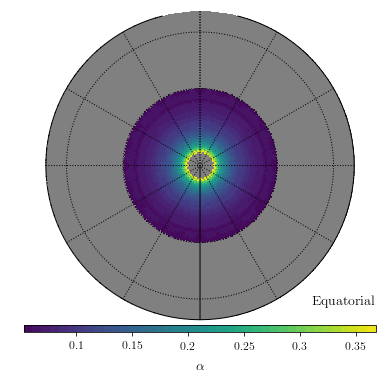

In [246]:
alpha_map = np.full(npix, hp.UNSEEN)
alpha_map[results['pix_disc']] = results['alpha']

theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = healpy_to_equatorial(theta, phi)
alpha_map[dec < np.deg2rad(-90) + radius] = hp.UNSEEN

comp.plot_skymap(alpha_map, cbar_title='$\mathrm{\\alpha}$', polar=True)

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       'radius-{}-degrees'.format(np.rad2deg(radius)),
                       '{}-alpha-skymap-polar.png'.format(config))
plt.savefig(outfile)

plt.show()

In [87]:
energy_mask = df_data.loc[:, 'reco_log_energy'] > 7.9
energy = df_data.loc[energy_mask, 'reco_log_energy']
ra = df_data.loc[energy_mask, 'lap_ra']
dec = df_data.loc[energy_mask, 'lap_dec']

theta, phi = equatorial_to_healpy(ra, dec)

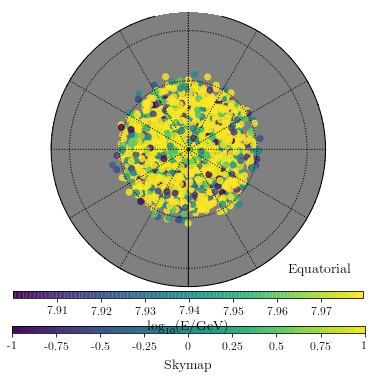

In [103]:
comp.plot_skymap(np.full(npix, hp.UNSEEN), polar=True)
fig = plt.gcf()
ax = plt.gca()

image = hp.projscatter(theta, phi, c=energy, alpha=0.8)
cbar = fig.colorbar(image,
                    orientation='horizontal',
                    aspect=50,
                    pad=0.01,
                    fraction=0.1,
                    ax=ax,
                    format=FormatStrFormatter('%g'),
                    shrink=1.0)
cbar.set_label('$\mathrm{\log_{10}(E/GeV)}$', size=14)
plt.show()